# CORDIC Algorithm

[Cordic](src=https://en.wikipedia.org/wiki/CORDIC) is a popular algorithm to calculate trigonometric functions, hyperbolic functions, square roots, multiplications, divisions, exponentials and logarithms. Cordic algorithms in present forms were first described by [Volder](src=https://www.computer.org/csdl/proceedings-article/afips/1959/50540257/12OmNqN6QXX) in 1959.

This notebook is divided into the following sections:
1. Overview of Cordic Algorithm
2. Implementation of CORDIC algorithm that supports circular, hyperbolic and linear coordinate system.
3. Verification including plotting for different iterations of cordic algorithm and functional accuracy range testing.

## Overview

It is assumed that the reader has basic understandings of CORDIC algorithm. The notebook's attempt is to implement the collection of higher level mathematical functions from the CORDIC algorithm. CORDIC algorithm are very useful when no hardware multiplier is available, (e.g. in simple microcontrollers and FPGAs), as the only operations it requires are additions, subtractions, bitshifts and lookup tables.

## Modes of Operation

CORDIC algorithms are classified into two mode of operations.

### Rotation Mode

If the desired angle is given in radians, CORDIC in rotation mode can be used to calculate the sine and cosine of an angle. 

![Ilustration of Cordic Algorithm]<img src="https://upload.wikimedia.org/wikipedia/commons/8/89/CORDIC-illustration.png" width="300">

Using CORDIC, one would start with the vector $v_0$:

$$ v_0 =\begin{bmatrix}1\\0\end{bmatrix}$$

In the first iteration, this vector is rotated 45$^{\circ}$ counterclockwise to get the vector $v_1$. Successive iterations rotate the vector in one or the other direction by size-decreasing steps, until the desired angle has been achieved. Step $i$ size is $tan^{-1}(2^{-i})$ for $i =0,1,2,...$. 

More formally, equations used in rotate mode in circular coordinate system are:

$$x_{i+1}=x_{i} - y_{i}d_{i}2^{-i}$$
$$y_{i+1}=x_{i}d_{i}2^{-i} + y_{i}$$
$$z_{i+1}=z_{i} - d_{i}tan^{-1}(2^{-i})$$

The last equation is the recurrence for decomposition/accumulation of angle.

### Vectoring mode

Vectoring mode operation requires a slight modification. It starts with a vector where the x-coordinate is positive and y-coordinate is arbitrary. Successive rotations have the goal of rotating the vector to the x-axis and therefore reducing the $y$ coordinate to zero. At each step, the value of $y$ determines the direction of the rotation. The final value of $\beta_i$ contains the total angle of rotation. The final value of $x$ will be the magnitude of the original vector scaled by K. The use of the vectoring mode is the transformation from rectangular to polar coordinates. 
$$ \beta_{i+1} = \beta_i - d_{i}tan^{-1}(2^{-i})$$
$$ K_i = \frac{1}{\sqrt{1 + 2^{-2i}}} $$

### Cordinate systems

CORDIC can be used in three different coordinate systems:

$$x_{i+1}=x_{i} - Cord*y_{i}d_{i}2^{-i}$$
$$y_{i+1}=x_{i}d_{i}2^{-i} + y_{i}$$
$$z_{i+1}=z_{i} - d_{i}A_i$$


| Coordinate system | Cord | A_i | Scaling | Iteration start index | Repeat iterations |
| --- | --- | --- | ---| --- | --- |
| Circular | +1 | $tan^{-1}(2^{-i})$| $sqrt(1+1/2^{2n})$ | 0 | None |
| Linear | 0 | $2^{-i}$ | 1 | 0 | None |
| Hyperbolic | -1 | $tanh^{-1}(2^{-i})$ | $sqrt(1-1/2^{2n})$ | 1 | (4,13,40,...k,...3k+1) |

The hyperbolic coordinate system needs to repeat the iteration in order to obtain convergence.

## IMPLEMENTATION

This jupyter notebook goes through the essence of the CORDIC algorithm for all the 3 coordinate systems. The algorithm is used to compute trigonometric functions, hyperbolic functions, division, multiplication, square-root, log and exponential functions. Range reduction and range testing is out of scope for this notebook.

In [1]:
import numpy as np
import math
from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

### CORDIC BASE
The following class implements core code that can support CORDIC operation for all the three coordinate systems, viz., circular, hyperbolic and linear.

In [2]:
class Cordic:
  def __init__(self, cord=1):
    # 1: circular, -1: hyperbolic, 0: linear
    self.coordinate = cord

  def romValuePerIteration(self, i):
    if self.coordinate == 1: #trigono
      return math.atan(2**(-1*i))
    elif self.coordinate == -1: #hyperbolic
      return math.atanh(2**(-1*i))
    else:
      return 2**(-1*i)

  # this is implemented as bitshift in hardware/FPGA
  # for this tutorial, we are simplifying it
  def simpleshift(self, x, d, i):
     return d*x*(2**(-1*i))

  # each cordic iteration block is modularized
  def iteration(self, x, y, z, mode, ROMval, i, compareVal):
    x0 = x
    if (mode): # rotation
      d = -1 if (z < compareVal) else 1
    else: # vectoring
      d = 1 if (y < compareVal) else -1
    x = x0 - self.coordinate*self.simpleshift(y,d,i)
    y = y + self.simpleshift(x0,d,i)
    z = z - d*ROMval
    return x, y, z

  # cordic rotation calls cordic iteration
  def iterations(self, x, y, z, mode, numIters, compareVal):
    i = 1 if (self.coordinate == -1) else 0
    x_vals = []
    y_vals = []
    z_vals = []
    k_hyp = 4 if (self.coordinate == -1) else -1
    while (i < numIters):
      ROMval = self.romValuePerIteration(i)
      x,y,z = self.iteration(x, y, z, mode, ROMval, i, compareVal)
      x_vals.append(x)
      y_vals.append(y)
      z_vals.append(z)
      if i == k_hyp: # repeat iteration for hyperbolic
        k_hyp = 3*k_hyp + 1
      else:
        i = i+1
    return x_vals, y_vals, z_vals

  def rotation(self, x, y, z, numIters, compareVal=0):
    return self.iterations(x, y, z, True, numIters, compareVal)

  def vectoring(self, x, y, z, numIters, compareVal=0):
    return self.iterations(x, y, z, False, numIters, compareVal)


### Trigonometric Function
Using CORDIC base object, the TrigonometricFunctions implements sin, cos, atan2, asin and acos methods.

In [3]:
class TrigonometricFunction:
  def __init__(self, debug=False):
    self.cordic = Cordic()
    # gain of the system
    gain_val = math.sqrt(2)
    for i in range (1, 20):
        gain_val = gain_val * math.sqrt(1 + 2**(-2 * i))
    self.K = 1/gain_val
    # debug returns list of all iteration values
    self.debug = debug
  
  def trimResult(self, z):
    if self.debug:
      return z
    else:
      return z[-1]

  def sincos(self, theta, iterations):
    x,y,z = self.cordic.rotation(self.K,0,theta,iterations)
    return self.trimResult(x), self.trimResult(y)

  def cos(self, theta, iterations):
    x, y = self.sincos(theta,iterations)
    return x

  def sin(self, theta, iterations):
    x,y = self.sincos(theta,iterations)
    return y

  def tan(self, theta, iterations):
    x,y = self.sincos(theta, iterations)
    if self.debug:
      res = [i / j for i, j in zip(y,x)]
      return res
    else:
      return y/x

  def asin(self, z, iterations):
    x,y,z = self.cordic.vectoring(self.K,0,0,iterations,-z)
    return self.trimResult(z)
  
  def acos(self, z, iterations):
    if self.debug:
      z = self.asin(z, iterations)
      z = [math.pi/2 - x for x in z]
      return z
    else:
      return math.pi/2 - self.asin(z, iterations)

  def atan2(self, y, x, iterations):
    x,y,z = self.cordic.vectoring(x, y, 0, iterations)
    return self.trimResult(z)

### Hyperbolic Functions
Using CORDIC base object, the HyperbolicFunction implements sinh, cosh, atanh and asinh methods.

In [4]:
class HyperbolicFunctions:
  def __init__(self, debug=False):
    self.cordic = Cordic(-1)
    # gain of the system
    gain_val = 1 
    for i in range (1, 20):
        gain_val = gain_val * math.sqrt(1 - 2**(-2 * i))
    self.K = 1/gain_val
    # debug returns list of all iteration values
    self.debug = debug

  def trimResult(self, z):
    if self.debug:
      return z
    else:
      return z[-1]

  def sincosh(self, theta, iterations):
    x,y,z = self.cordic.rotation(self.K,0,theta,iterations)
    return self.trimResult(x), self.trimResult(y)

  def cosh(self, theta, iterations):
    x, y = self.sincosh(theta,iterations)
    return x

  def sinh(self, theta, iterations):
    x,y = self.sincosh(theta,iterations)
    return y

  def tanh(self, theta, iterations):
    x,y = self.sincosh(theta, iterations)
    if self.debug:
      res = [i / j for i, j in zip(y,x)]
      return res
    else:
      return y/x

  def asinh(self, z, iterations):
    x,y,z = self.cordic.vectoring(self.K,0,0,iterations,-z)
    return self.trimResult(z)
  
  def atanh(self, y, iterations):
    x,y,z = self.cordic.vectoring(1, y, 0, iterations)
    return self.trimResult(z)

### Math Functions
Using CORDIC base object, the MathFunction implements product, divide, sqrt, exp and log methods.

In [5]:
class MathFunctions:
  def __init__(self, debug=False):
    self.cordic = Cordic(0)
    self.hyperbolic = Cordic(-1)
    # gain of the system
    gain_val = 1 
    for i in range (1, 20):
        gain_val = gain_val * math.sqrt(1 - 2**(-2 * i))
    self.K = 1/gain_val
    # debug returns list of all iteration values
    self.debug = debug

  def trimResult(self, z):
    if self.debug:
      return z
    else:
      return z[-1]

  def product(self, x,y, iterations):
    x,y,z = self.cordic.rotation(y,0,x,iterations)
    return self.trimResult(y)

  def divide(self, x,y, iterations):
    x,y,z = self.cordic.vectoring(y,x,0,iterations)
    return self.trimResult(z)


  def sqrt(self, v, iterations):
    x,y,z = self.hyperbolic.vectoring(v+1/4, v-1/4, 0, iterations)
    if self.debug:
      z = [self.K*y for y in x]
      return z
    else:
      return self.K*x[-1]

  def exp(self, z, iterations):
    x,y,z = self.hyperbolic.rotation(self.K, self.K, z, iterations)
    return self.trimResult(x)
  
  def log(self, v, iterations):
    assert ((v-1)/(v+1) < 0.807)
    x,y,z = self.hyperbolic.vectoring(v+1, v-1, 0, iterations)
    if self.debug:
      z = [2*y for y in z]
      return z
    else:
      return self.K*z[-1]

# Verification

The following section verifies the trigonomentric, hyperbolic and math functions. 

## Verify Trigonometric functions
1. Plot value vs iteration for trigonometric functions

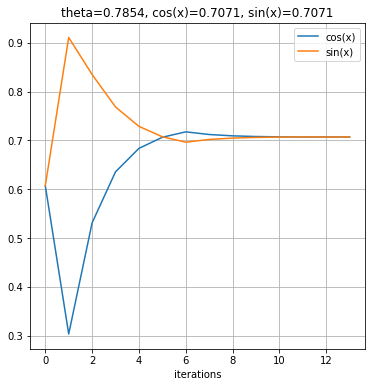

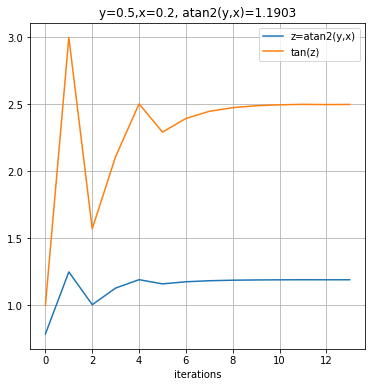

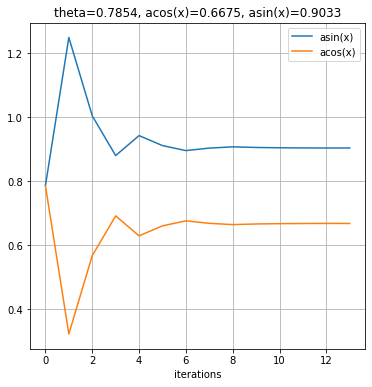

In [6]:
# Plotting
def plot(y_vals, x_vals, y_label, x_label, title):
    fig, axs = plt.subplots(1, 1, figsize=(6,6))
    for i in range(len(y_label)):
        axs.plot(x_vals, y_vals[i], label=y_label[i])
    axs.set_title(title)
    axs.set_xlabel(x_label)
    axs.grid()
    plt.legend()
    plt.show()

trig = TrigonometricFunction(True)
theta = math.pi/4
numiters = 14
x,y = trig.sincos(theta, numiters)
plot([x, y], range(0,len(x),1), ['cos(x)', 'sin(x)'],'iterations', 
     'theta=' + str(round(theta,4)) + ', cos(x)=' + str(round(math.cos(theta),4)) 
     + ', sin(x)=' + str(round(math.sin(theta),4)))

numiters=14
z = trig.atan2(0.5, 0.2, numiters)
w = trig.tan(z[-1], numiters)
plot([z,w], range(0,len(z),1), ['z=atan2(y,x)','tan(z)'],'iterations', 
     'y='+str(0.5) + ',x=' + str(0.2) + ', atan2(y,x)=' + str(round(math.atan2(0.5,0.2),4)))

numiters=14
theta = math.pi/4
z1 = trig.asin(theta, numiters)
z2 = trig.acos(theta, numiters)
plot([z1, z2], range(0,len(z1),1), ['asin(x)', 'acos(x)'],'iterations', 
     'theta=' + str(round(theta,4))  + ', acos(x)=' + str(round(math.acos(theta),4)) +
     ', asin(x)=' + str(round(math.asin(theta),4)))

2. Verify functional behavior in the first quadrant for trigonometric functions.

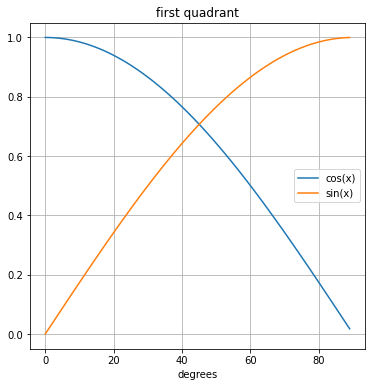

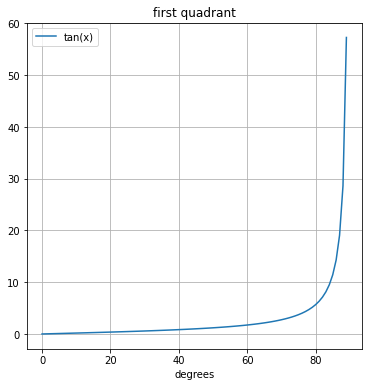

In [7]:
def verify_range():
  trig = TrigonometricFunction()
  x_vals = []
  y_vals = []
  w_vals = []
  numIters = 15
  for i in range(0,90,1):
    theta = (math.pi*i)/180
    y = trig.sin(theta,numIters)
    x = trig.cos(theta,numIters)
    w = trig.tan(theta,numIters)
    assert np.isclose(x, math.cos(theta),rtol=1e-04, atol=1e-04)
    assert np.isclose(y, math.sin(theta),rtol=1e-04, atol=1e-04)
    assert np.isclose(w, math.tan(theta),rtol=1e-03, atol=1e-03)
    z = trig.atan2(y,x,numiters)
    assert np.isclose(z,math.atan2(y,x),rtol=1e-04,atol=1e-04)
    x_vals.append(x)
    y_vals.append(y)
    w_vals.append(w)
  return x_vals, y_vals, w_vals

x_vals, y_vals, w_vals = verify_range()
plot([x_vals, y_vals], range(0,len(x_vals),1), ['cos(x)', 'sin(x)'],
     'degrees', 'first quadrant')
plot([w_vals], range(0,len(x_vals),1), ['tan(x)'],
     'degrees', 'first quadrant')

3. Plot values for different iterations in first quadrant.





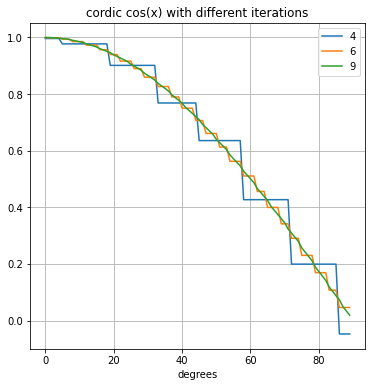

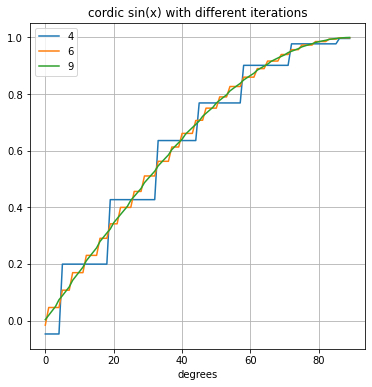

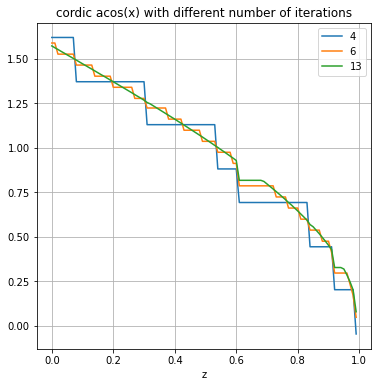

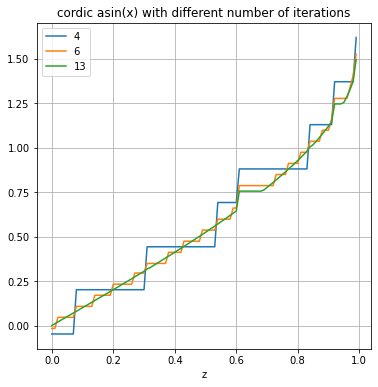

In [8]:
def plot_sincos_iterations(iters):
  trig = TrigonometricFunction()
  x_vals = []
  y_vals = []
  ylabels = []
  for it in range(len(iters)):
    ylabels.append(str(iters[it]))
    x_vals.append([])
    y_vals.append([])
  #x_vals = np.ndarray(shape=(len(iters),1))
  #y_vals = np.ndarray(shape=(len(iters),1))
  for i in range(0,90,1):
    theta = (math.pi*i)/180
    for it in range(len(iters)):
        x,y = trig.sincos(theta,iters[it])
        x_vals[it].append(x)
        y_vals[it].append(y)
  plot(x_vals, range(0,len(x_vals[0]),1), ylabels,'degrees', 
       'cordic cos(x) with different iterations')
  plot(y_vals, range(0,len(y_vals[0]),1), ylabels,'degrees', 
       'cordic sin(x) with different iterations')

iters = [4,6,9]
plot_sincos_iterations(iters)

def plot_asinacos_iterations(iters):
  trig = TrigonometricFunction()
  x_vals = []
  y_vals = []
  ylabels = []
  for it in range(len(iters)):
    ylabels.append(str(iters[it]))
    x_vals.append([])
    y_vals.append([])
  z_vals = []
  for i in range(0,100,1):
    z = i/100
    z_vals.append(z)
    for it in range(len(iters)):
        y = trig.asin(z,iters[it])
        x = trig.acos(z,iters[it])
        x_vals[it].append(x)
        y_vals[it].append(y)
    assert np.isclose(x_vals[-1][-1],math.acos(z),rtol=1e-01,atol=1e-01)
    assert np.isclose(y_vals[-1][-1],math.asin(z),rtol=1e-01,atol=1e-01)
  plot(x_vals, z_vals, ylabels,'z', 
       'cordic acos(x) with different number of iterations')
  plot(y_vals, z_vals, ylabels,'z', 
       'cordic asin(x) with different number of iterations')

iters = [4,6,13]
plot_asinacos_iterations(iters)

## Verify Trigonometric functions
1. Plot value vs iteration for trigonometric functions

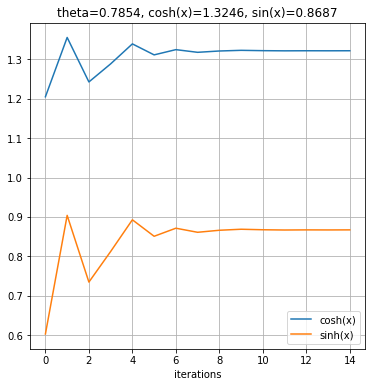

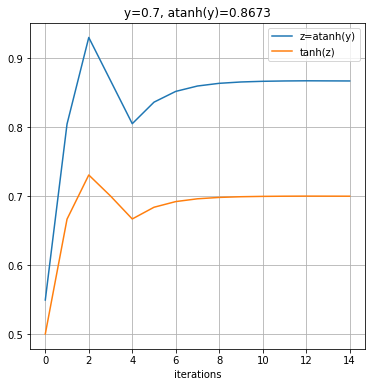

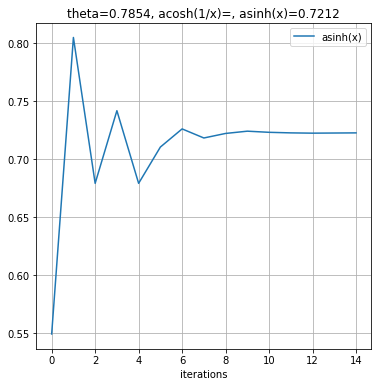

In [9]:
hypb = HyperbolicFunctions(True)
theta = math.pi/4
numiters = 14
x,y = hypb.sincosh(theta, numiters)
plot([x, y], range(0,len(x),1), ['cosh(x)', 'sinh(x)'],'iterations', 
     'theta=' + str(round(theta,4)) + ', cosh(x)=' + str(round(math.cosh(theta),4)) 
     + ', sin(x)=' + str(round(math.sinh(theta),4)))

z = hypb.atanh(0.7, numiters)
w = hypb.tanh(z[-1], numiters)
plot([z,w], range(0,len(z),1), ['z=atanh(y)','tanh(z)'],'iterations', 
     'y='+str(0.7) + ', atanh(y)=' + str(round(math.atanh(0.7),4)))

z = hypb.asinh(theta, numiters)
plot([z], range(0,len(z),1), ['asinh(x)'],'iterations', 
     'theta=' + str(round(theta,4))  + ', acosh(1/x)='  +
     ', asinh(x)=' + str(round(math.asinh(theta),4)))

2. Verify functional behavior in the first quadrant for hyperbolic functions

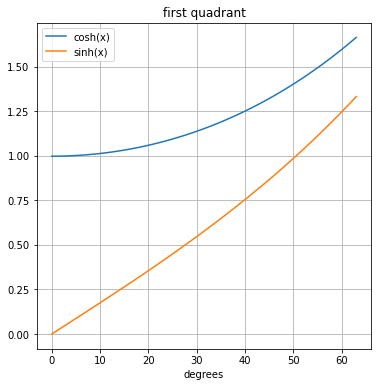

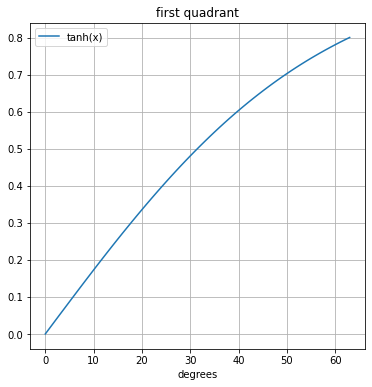

In [10]:
def verify_range_hypb():
  hypb = HyperbolicFunctions()
  x_vals = []
  y_vals = []
  w_vals = []
  numIters = 15
  # Hyperbolic rotation limit to |z| < 1.11 (or 64 degrees)
  for i in range(0,64,1):
    theta = (math.pi*i)/180
    y = hypb.sinh(theta,numIters)
    x = hypb.cosh(theta,numIters)
    w = hypb.tanh(theta,numIters)
    assert np.isclose(x, math.cosh(theta),rtol=1e-02, atol=1e-02)
    assert np.isclose(y, math.sinh(theta),rtol=1e-02, atol=1e-02)
    assert np.isclose(w, math.tanh(theta),rtol=1e-03, atol=1e-03)
    z = hypb.atanh(w,numiters)
    assert np.isclose(z,math.atanh(w),rtol=1e-04,atol=1e-04)
    x_vals.append(x)
    y_vals.append(y)
    w_vals.append(w)
  return x_vals, y_vals, w_vals

x_vals, y_vals, w_vals = verify_range_hypb()
plot([x_vals, y_vals], range(0,len(x_vals),1), ['cosh(x)', 'sinh(x)'],
     'degrees', 'first quadrant')
plot([w_vals], range(0,len(x_vals),1), ['tanh(x)'],
     'degrees', 'first quadrant')

3. Plot values for different iterations in first quadrant.


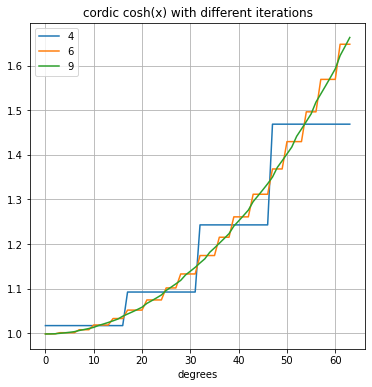

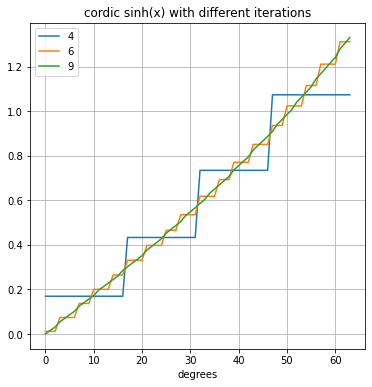

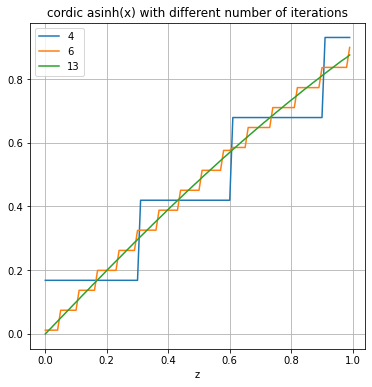

In [11]:
def plot_sincosh_iterations(iters):
  hypb = HyperbolicFunctions()
  x_vals = []
  y_vals = []
  ylabels = []
  for it in range(len(iters)):
    ylabels.append(str(iters[it]))
    x_vals.append([])
    y_vals.append([])
  #x_vals = np.ndarray(shape=(len(iters),1))
  #y_vals = np.ndarray(shape=(len(iters),1))
  for i in range(0,64,1):
    theta = (math.pi*i)/180
    for it in range(len(iters)):
        x,y = hypb.sincosh(theta,iters[it])
        x_vals[it].append(x)
        y_vals[it].append(y)
  plot(x_vals, range(0,len(x_vals[0]),1), ylabels,'degrees', 
       'cordic cosh(x) with different iterations')
  plot(y_vals, range(0,len(y_vals[0]),1), ylabels,'degrees', 
       'cordic sinh(x) with different iterations')

iters = [4,6,9]
plot_sincosh_iterations(iters)

def plot_asinh_iterations(iters):
  hypb = HyperbolicFunctions()
  y_vals = []
  ylabels = []
  for it in range(len(iters)):
    ylabels.append(str(iters[it]))
    y_vals.append([])
  z_vals = []
  for i in range(0,100,1):
    z = i/100
    z_vals.append(z)
    for it in range(len(iters)):
        y = hypb.asinh(z,iters[it])
        y_vals[it].append(y)
    assert np.isclose(y_vals[-1][-1],math.asinh(z),rtol=1e-01,atol=1e-01)
  plot(y_vals, z_vals, ylabels,'z', 
       'cordic asinh(x) with different number of iterations')

iters = [4,6,13]
plot_asinh_iterations(iters)

## Verify Math functions
1. Plot value vs iteration for trigonometric functions

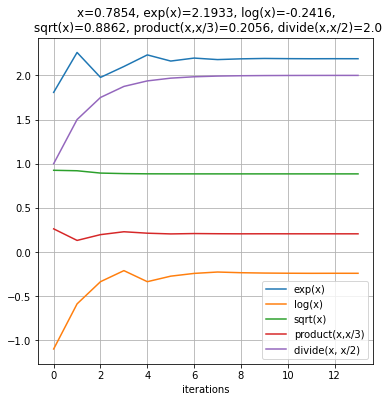

In [12]:
mathfcn = MathFunctions(True)
numiters = 14
x = math.pi/4
z1 = mathfcn.sqrt(x, numiters)[:numiters]
z2 = mathfcn.log(x, numiters)[:numiters]
z3 = mathfcn.exp(x, numiters)[:numiters]
z4 = mathfcn.product(x, x/3, numiters)
z5 = mathfcn.divide(x, x/2, numiters)
plot([z3, z2, z1, z4, z5], range(0,len(z1),1), ['exp(x)', 'log(x)', 'sqrt(x)', 
                                                'product(x,x/3)', 'divide(x, x/2)'],
     'iterations', 'x=' + str(round(x,4)) + ', exp(x)=' + str(round(math.exp(x),4)) 
     + ', log(x)=' + str(round(math.log(x),4)) + ',\n sqrt(x)=' + str(round(math.sqrt(x),4))
     + ', product(x,x/3)=' + str(round(x*x/3,4)) + ', divide(x,x/2)=' + str(round(x/(x/2), 4)))

2. Verify functional behavior for math functions

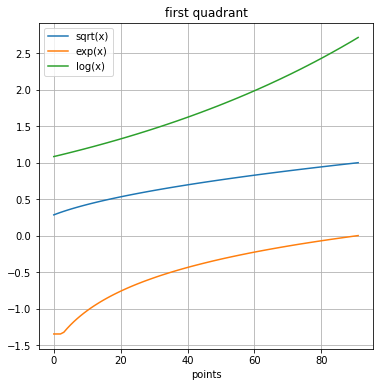

In [13]:
def verify_range_math():
  mathfcn = MathFunctions()
  x_vals = []
  y_vals = []
  w_vals = []
  z_vals = []
  numIters = 15
  # Hyperbolic rotation limit to |z| < 1.11 (or 64 degrees)
  for i in range(8,100,1):
    x = i/99
    z1 = mathfcn.sqrt(x, numiters)
    z2 = mathfcn.log(x, numiters)
    z3 = mathfcn.exp(x, numiters)
    z4 = mathfcn.product(x, x/3, numiters)
    z5 = mathfcn.divide(x, x/2, numiters)
    assert np.isclose(z1, math.sqrt(x),rtol=1e-02, atol=1e-02)
    #assert np.isclose(z2, math.log(x),rtol=1e-01, atol=1e-01)
    assert np.isclose(z3, math.exp(x),rtol=1e-01, atol=1e-01)
    x_vals.append(x)
    y_vals.append(z1)
    w_vals.append(z2)
    z_vals.append(z3)
  return x_vals, y_vals, w_vals, z_vals

x_vals, y_vals, w_vals, z_vals = verify_range_math()
plot([y_vals, w_vals, z_vals], range(0,len(x_vals),1), ['sqrt(x)', 'exp(x)', 'log(x)'],
     'points', 'first quadrant')

# References
1. [The CORDIC Computing Technique: Jack Volder 1959](src=https://www.computer.org/csdl/pds/api/csdl/proceedings/download-article/12OmNqN6QXX/pdf)
2. [A unified algorithm for elementary functions - J. S. Walther 1971](src=http://home.citycable.ch/pierrefleur/Jacques-Laporte/Welther-Unified%20Algorithm.pdf)
3. [Generalized Hyperbolic CORDIC and its Logarithmic and Exponential Computation: Yuanyong Luo et. al.](src=https://ieeexplore.ieee.org/document/8738918)
4. [CORDIC - Wikipedia](src=https://en.wikipedia.org/wiki/CORDIC)
5. [CORDIC - Wikibooks](src=https://en.wikibooks.org/wiki/Digital_Circuits/CORDIC)





Please contact [Shomit Dutta](mailto:shomitdutta@gmail.com) for any follow-up on this page.